In [12]:
import plotly
import plotly.graph_objs as go

# Importing Python and external packages


import os
import sys
import importlib
from importlib import reload 
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import scipy
from scipy import stats
from scipy import signal
from scipy.signal import spectrogram, hann, butter, filtfilt, freqz

import seaborn as sns
import pingouin as pg
from itertools import combinations
from statannotations.Annotator import Annotator

import openpyxl
from openpyxl import Workbook, load_workbook
# import xlrd
import pickle
import json
import csv
import h5py
import fooof
from fooof.plts.spectra import plot_spectrum

#mne
from pathlib import Path
import mne_bids
from mne_bids import (
    BIDSPath,
    inspect_dataset,
    mark_channels)
import mne
from mne.time_frequency import tfr_morlet 

In [19]:
jennifer_user_path = os.getcwd()
while jennifer_user_path[-14:] != 'jenniferbehnke':
    jennifer_user_path = os.path.dirname(jennifer_user_path)

# directory to this Repository
project_path = os.path.join(jennifer_user_path, 'code', 'Monopolar_power_estimation', 'monopolar_directional_beta')
sys.path.append(project_path)

os.chdir(project_path)

import src.monopolar_bssu.utils.find_folders as find_folders
importlib.reload(find_folders)

# import PyPerceive

project_path = find_folders.chdir_repository("Py_Perceive")

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)

import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as PyPerceive_find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

# import meet

project_path = find_folders.chdir_repository("meet")

import meet as meet

# import all functions from BetaSenSightLongterm
project_path = find_folders.chdir_repository("monopolar_directional_beta")


# externalized LFP
import src.monopolar_bssu.externalized_lfp.externalized_lfp as externalized
import src.monopolar_bssu.externalized_lfp.feats_ssd as feats_ssd

# monopolar Referencing
import src.monopolar_bssu.monopol_bssu_methods.MonoRef_JLB as MonoRefJLB
#import src.bssu.monopolar.GroupMonopolarPSD as groupMonopol
import src.monopolar_bssu.monopol_bssu_methods.monoRef_weightPsdAverageByCoordinateDistance as MonoRefWeightedCoordinateDistance
import src.monopolar_bssu.monopol_bssu_methods.bssu_contacts_maximal_beta as bssu_contacts
import src.monopolar_bssu.monopol_bssu_methods.monoRef_Strelow as detec_strelow

# Power Spectra
import src.monopolar_bssu.power_spectra.power_spectra_externalized as power_spectra_externalized

# Clinical stimulation parameters
import src.monopolar_bssu.clinical_contacts.activeStimulationContacts as activeStimContacts

# comparison analysis
import src.monopolar_bssu.comparison_analysis.monopol_comparison_tests as monopol_comparison_tests
import src.monopolar_bssu.comparison_analysis.monopol_method_comparison as monopol_method_comparison

# utility functions
import src.monopolar_bssu.utils.loadResults as loadResults
import src.monopolar_bssu.utils.find_folders as find_folders
import src.monopolar_bssu.utils.io_externalized as io_externalized
import src.monopolar_bssu.utils.io_percept as io_percept
import src.monopolar_bssu.utils.io_monopolar_comparison as io_monopolar_comparison
import src.monopolar_bssu.utils.externalized_lfp_preprocessing as externalized_lfp_preprocessing
import src.monopolar_bssu.utils.percept_lfp_preprocessing as percept_lfp_preprocessing
import src.monopolar_bssu.utils.tmsi_poly5reader as tmsi_poly5reader

# short time stability 
import src.monopolar_bssu.short_time_stability_power.externalized_short_chunks as externalized_short_chunks
import src.monopolar_bssu.short_time_stability_power.number_needed_to_record as nnr


importlib.reload(externalized)
importlib.reload(feats_ssd)
importlib.reload(loadResults)
importlib.reload(MonoRefJLB)
importlib.reload(MonoRefWeightedCoordinateDistance)
importlib.reload(bssu_contacts)
importlib.reload(detec_strelow)
importlib.reload(power_spectra_externalized)
importlib.reload(activeStimContacts)
importlib.reload(monopol_comparison_tests)
importlib.reload(monopol_method_comparison)
importlib.reload(loadResults)
importlib.reload(find_folders)
importlib.reload(io_externalized)
importlib.reload(io_percept)
importlib.reload(io_monopolar_comparison)
importlib.reload(externalized_lfp_preprocessing)
importlib.reload(percept_lfp_preprocessing)
importlib.reload(tmsi_poly5reader)
importlib.reload(externalized_short_chunks)
importlib.reload(nnr)


# load if you want to see complete Dataframes
pd.set_option("display.max_rows", None)

Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data
Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data
Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data
Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data


## Permutation test - NNR

Step 1: Data 
- for each patient hemisphere, only one channel with highest beta (beta rank 1) over rec duration of 2 minutes is selected
- each of the selected channels are cut into 20 sec epochs with 50 % overlap
- for each window the beta rank across all other channels within the same 20sec window is calculated
- format: Dataframe with rows=sub_hem_chan and columns=beta ranks across multiple 20sec windows

Step 2: for a given number of windows, e.g. 3x
- per sub_hem: randomly pick n=3 out of existing windows
- per sub_hem: determine from the randomly picked windows if the most common rank == 1 -> if True = stable 
- if more than one rank is most common == not stable
- across sub_hem: determine the proportion of patients with stable ranks
- REPEAT n=1000 and plot the distribution of proportion of patients with stable ranks

Step 3: Test against the goal of at least 80% of patients achieving stable ranks
- p-value calculation: is 0.8 within the confidential interval of the given distribution?
- if the goal of 0.8 is significantly extreme and outside of the confidential interval: p value is significant, which means we cannot say that 80% of patients achieved stable ranks when 20s windows are recorded 3 times

Step 4: 
- REPEAT the same calculation for all number of recordings (2 - 10)


In [34]:
all_power_data = externalized_short_chunks.rank_power_2min_all_epochs(
        incl_sub=["all"],
        filtered="notch_and_band_pass_filtered", 
        freq_band="beta", 
        channel_group="all",
        sec_per_epoch=20)

Power spectrum power_spectrum_20_sec_11 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A1C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1B1C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2A2B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2A2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2B2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Left 01 is a float!: nan
Power spectrum power_spectrum_20_s

In [35]:
data = all_power_data["maximal_power_data"]

In [36]:
ranked_power_sec = pd.DataFrame()
only_one_2min_rank_data = pd.DataFrame()

# rank average power of each 20 sec recording within the group of channels
id_list = data["patient_id"].unique() # list of subjects

for id in id_list:

    id_data = data[data["patient_id"] == id]
        
    # check if number of epochs doesn't exist
    if len(id_data.number_of_epochs.values) == 0:
        print(f"Number of epochs does not exist for {id}")
        continue

    number_of_epochs = id_data.number_of_epochs.values[0]
    print(id, number_of_epochs)
    id_data_copy = id_data.copy()

    # rank power of each epoch recording
    for i in range(1, number_of_epochs + 1):
        id_data_copy[f"rank_sec_{i}"] = id_data_copy[f"power_spectrum_sec_{i}_mean"].rank(ascending=False)
    
    ranked_power_sec = pd.concat([ranked_power_sec, id_data_copy], ignore_index=True)

    # only keep maximal power channel
    rank_2min_power_channel = ranked_power_sec[ranked_power_sec["rank_2min"] == 1]
    only_one_2min_rank_data = pd.concat([only_one_2min_rank_data, rank_2min_power_channel], ignore_index=True)



024_Right_01 11
024_Left_1A2A 11
025_Right_1A2A 10
025_Left_1A2A 10
029_Right_2B2C 9
029_Left_1B1C 9
030_Right_1B2B 10
047_Right_1A2A 11
047_Left_1C2C 11
049_Right_01 11
052_Right_1B2B 9
052_Left_01 9
056_Right_1A2A 11
056_Left_23 11
059_Right_1B2B 11
059_Left_01 11
061_Left_1C2C 11
064_Right_1A1B 11
064_Left_2A2C 10
067_Right_1A2A 10
067_Left_01 11
069_Right_1B2B 9
071_Left_1C2C 11
072_Left_1C2C 11
075_Left_1A2A 11
077_Right_23 10
079_Right_1A2A 11
079_Left_1A2A 11
080_Right_01 10
080_Left_1B2B 10


### Main Function

Power spectrum power_spectrum_20_sec_11 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A1C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1B1C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2A2B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2A2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2B2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Left 01 is a float!: nan
Power spectrum power_spectrum_20_s

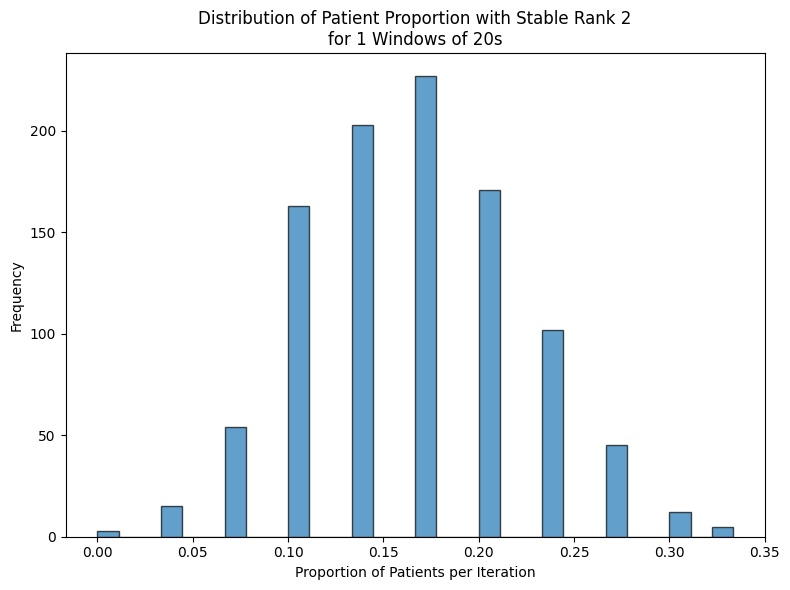

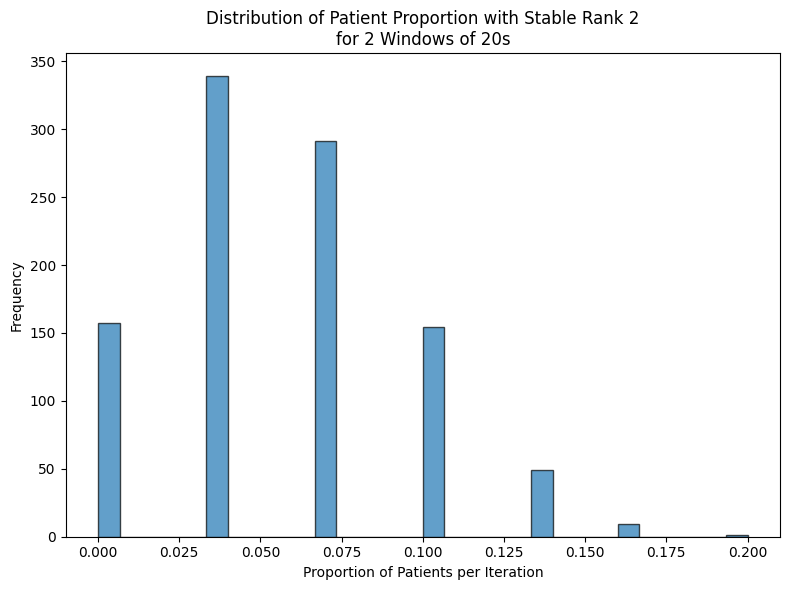

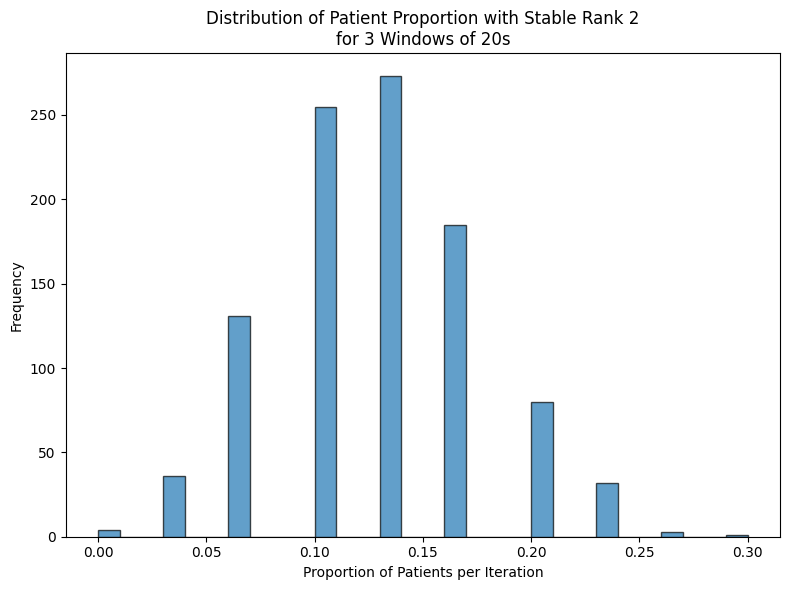

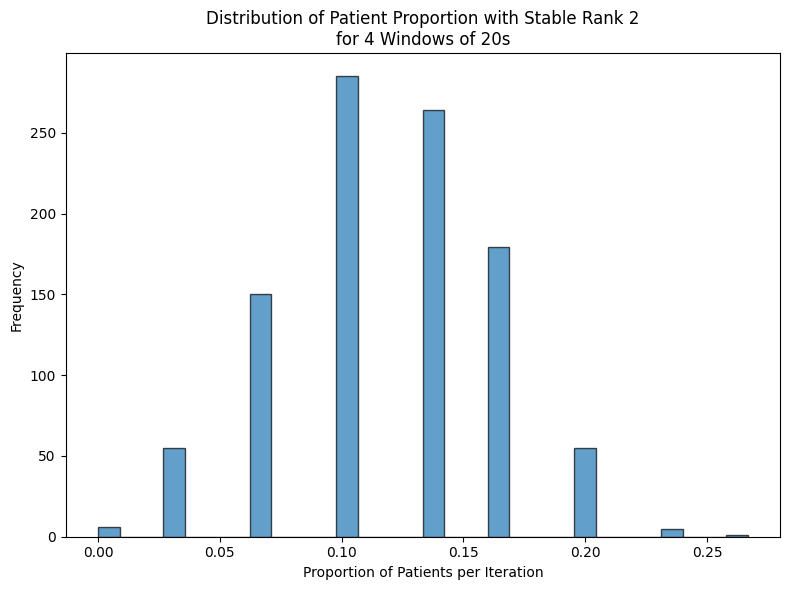

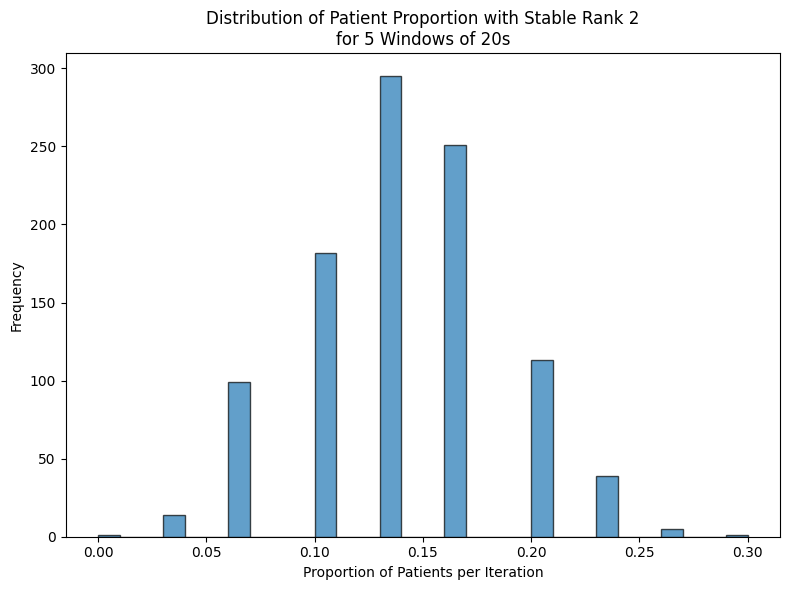

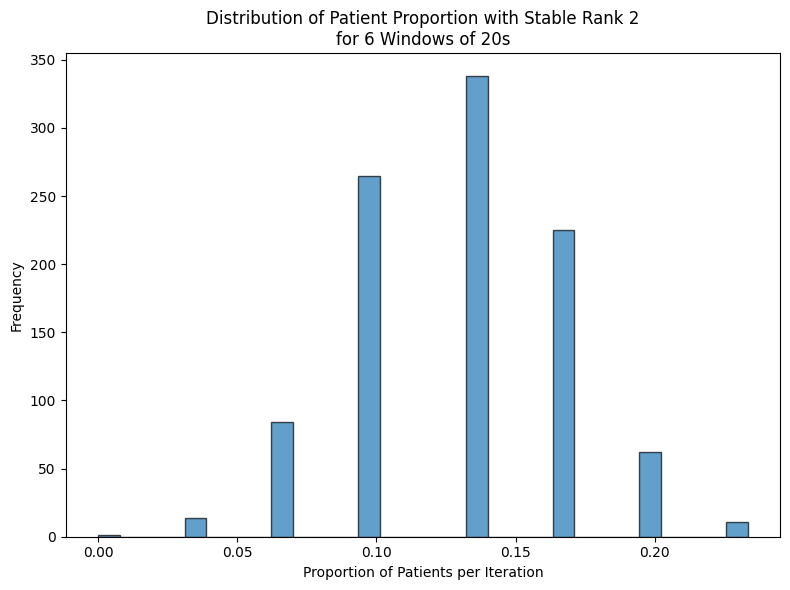

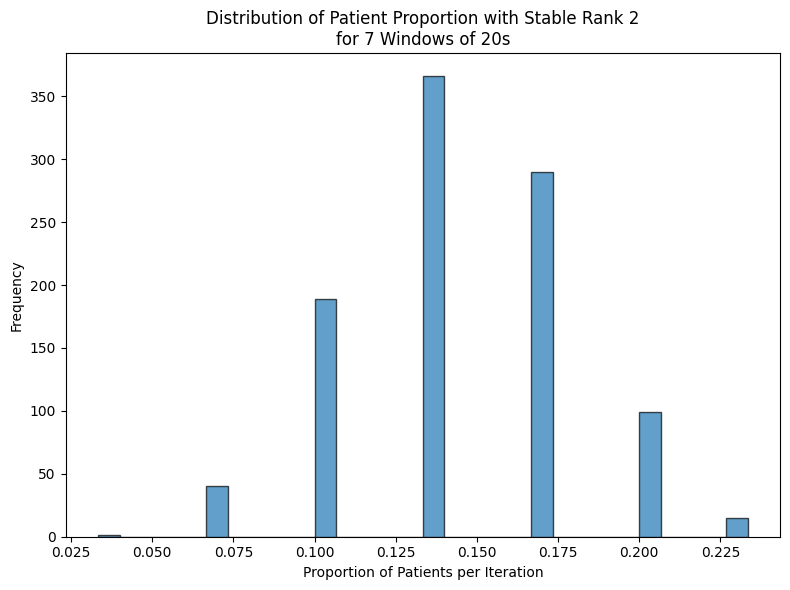

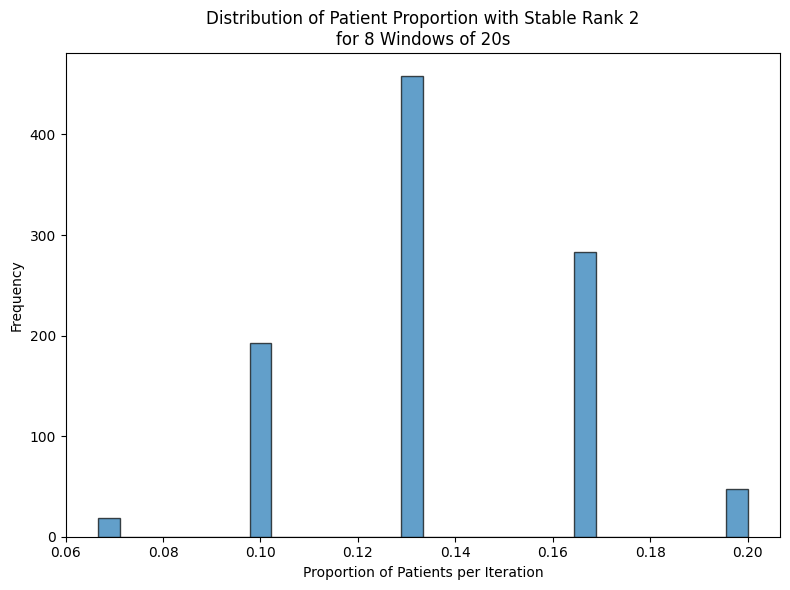

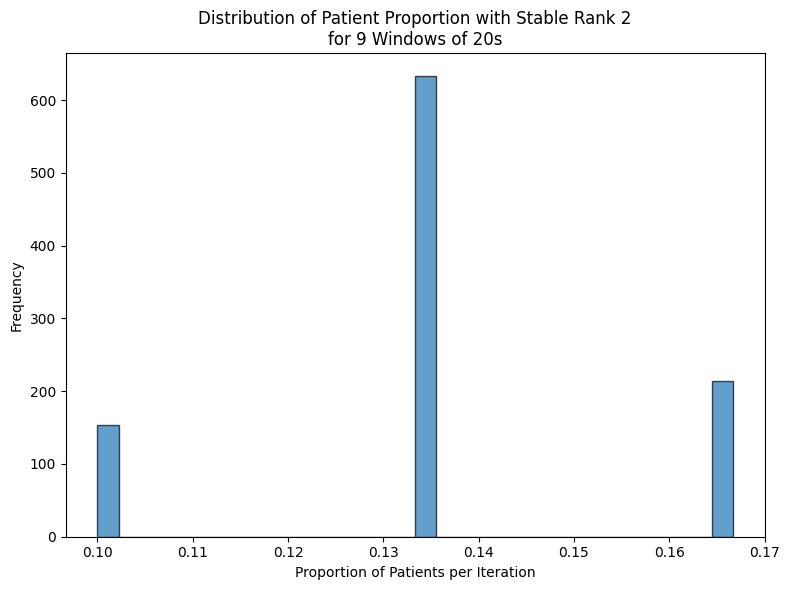

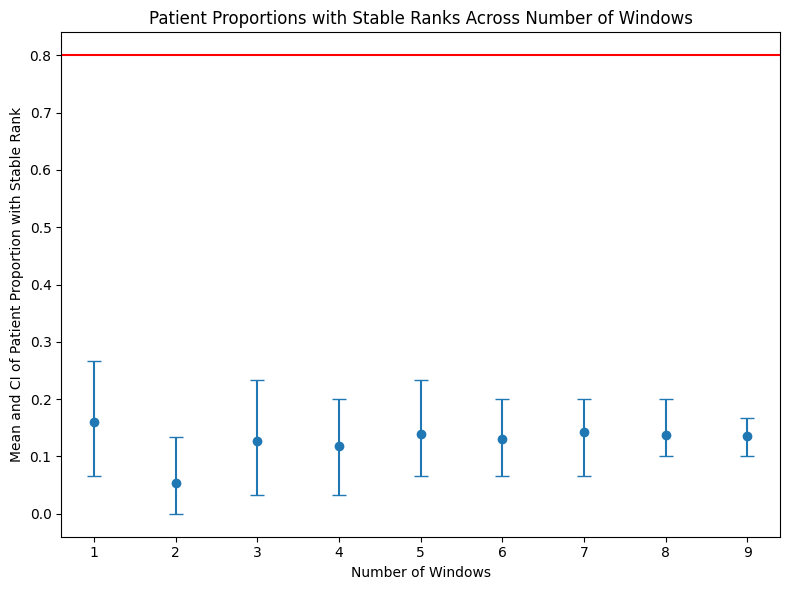

In [21]:
results_dataframe, value_counts_results = nnr.main_rank_stability_test(
    incl_sub=["all"],
    sec_per_epoch=20,
    freq_band="beta",
    channel_group="segm",
    rank_of_interest=1,
    num_iterations=1000,
    goal_stability=0.8,
    num_windows_lowest=1,
    num_windows_highest=9
)

In [53]:
results_dataframe


,number_windows,sec_per_epoch,mean_proportion,ci_lower,ci_upper,p_value,channel_group,freq_band,distribution,mean-ci_lower,ci_upper-mean
0,1,20,0.715967,0.600000,0.833333,0.131,segm,beta,not_normal_distribution,0.115967,0.117367
1,2,20,0.598700,0.499167,0.700000,0.001,segm,beta,not_normal_distribution,0.099533,0.101300
2,3,20,0.738267,0.633333,0.833333,0.171,segm,beta,not_normal_distribution,0.104933,0.095067
3,4,20,0.709167,0.600000,0.800000,0.064,segm,beta,not_normal_distribution,0.109167,0.090833
4,5,20,0.756767,0.666667,0.833333,0.259,segm,beta,not_normal_distribution,0.090100,0.076567
5,6,20,0.743733,0.666667,0.833333,0.168,segm,beta,not_normal_distribution,0.077067,0.089600
6,7,20,0.785067,0.700000,0.833333,0.542,segm,beta,not_normal_distribution,0.085067,0.048267
7,8,20,0.770867,0.700000,0.833333,0.357,segm,beta,not_normal_distribution,0.070867,0.062467
8,9,20,0.801700,0.766667,0.833333,0.810,segm,beta,not_normal_distribution,0.035033,0.031633


In [51]:
# This gives a summary of the frequency of patient proportions per iteration
# keys: range from num_windows_lowerst to num_windows_highest

value_counts_results[8]

Counter({0.7333333333333333: 225,
         0.8333333333333334: 90,
         0.8: 254,
         0.7666666666666667: 369,
         0.7: 44,
         0.8666666666666667: 11,
         0.6666666666666666: 7})

### Observe the data

In [22]:
rank_data = nnr.load_ranks(
    incl_sub=["all"],
    sec_per_epoch=20,
    freq_band="beta",
    channel_group="ring",
    rank_of_interest=1
)

Power spectrum power_spectrum_20_sec_11 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A1C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1B1C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2A2B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2A2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2B2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Left 01 is a float!: nan
Power spectrum power_spectrum_20_s

In [23]:
# ranks for #1 segmented channel (1/9)
rank_data

,0,1,2,3,4,5,6,7,8,9,10
024_Right_01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
024_Left_12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
025_Right_01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
025_Left_12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN
029_Right_01,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
029_Left_01,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,NaN,NaN
030_Right_12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
047_Right_12,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0
047_Left_01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
049_Right_01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Single Functions

Power spectrum power_spectrum_20_sec_11 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A1C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1B1C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2A2B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2A2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2B2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Left 01 is a float!: nan
Power spectrum power_spectrum_20_s

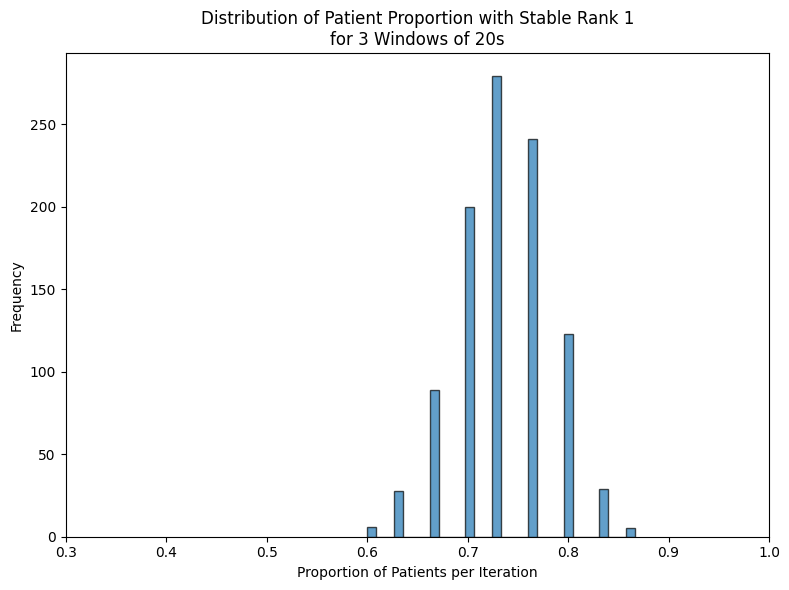

In [11]:
stability_proportion = nnr.stability_distribution_plot(
    incl_sub=["all"],
    sec_per_epoch=20,
    freq_band="beta",
    channel_group="segm",
    rank_of_interest=1,
    num_windows=3,
    num_iterations=1000
)

In [7]:
def most_frequent_integer(lst):
    count_dict = {}
    for num in lst:
        if num in count_dict:
            count_dict[num] += 1
        else:
            count_dict[num] = 1
    max_count = max(count_dict.values())
    most_frequent = [num for num, count in count_dict.items() if count == max_count]
    return most_frequent

# Example usage
example_list = [1,1,2,2]
result = most_frequent_integer(example_list)
print(result)

[1, 2]


In [10]:
all_windows = np.arange(1, 10)
random_choice = np.random.choice(all_windows, size=3, replace=False)

random_choice = list(random_choice)
random_choice

[3, 6, 9]

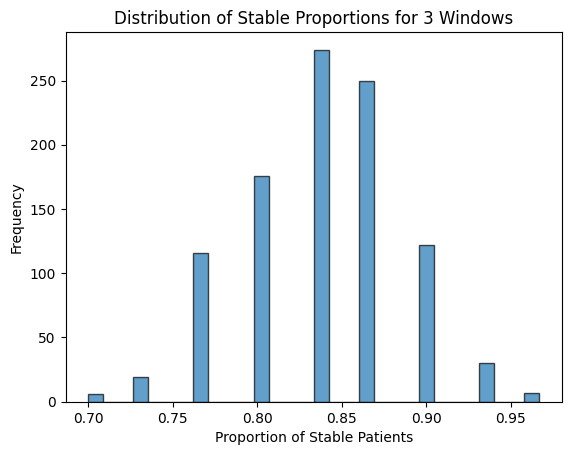

In [21]:
def check_stability(data, num_windows, stability_threshold, num_iterations):
    stable_proportions = []
    for _ in range(num_iterations):
        stable_counts = 0
        for patient_data in data.itertuples(index=False):
            
            filtered_patient_data = np.array(patient_data)[~np.isnan(patient_data)]            
            selected_windows = np.random.choice(filtered_patient_data, size=num_windows, replace=False)
            
            proportion_rank_1 = np.sum(selected_windows == 1) / num_windows
            
            stability = proportion_rank_1 >= stability_threshold
            
            stable_counts += stability
        stable_proportion = stable_counts / len(data)

        stable_proportions.append(stable_proportion)
    return stable_proportions

# Parameters
num_iterations = 1000
stability_threshold = 0.8

# Test with 3 windows
stable_proportions_3_windows = check_stability(rank_data, 3, stability_threshold, num_iterations)

# Plot the distribution
plt.hist(stable_proportions_3_windows, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Proportion of Stable Patients')
plt.ylabel('Frequency')
plt.title('Distribution of Stable Proportions for 3 Windows')
plt.show()

In [22]:
# Shapiro-Wilk Test
stat, p = stats.shapiro(stable_proportions_3_windows)
print('Shapiro-Wilk Test')
print('Statistic:', stat)
print('p-value:', p)

# Interpretation
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk Test
Statistic: 0.9554710388183594
p-value: 7.323579872603179e-17
Sample does not look Gaussian (reject H0)


In [19]:
def calculate_p_value(stable_proportions, goal):
    mean_proportion = np.mean(stable_proportions)
    ci_lower = np.percentile(stable_proportions, 2.5)
    ci_upper = np.percentile(stable_proportions, 97.5)
    p_value = (np.sum(np.array(stable_proportions) >= goal) / len(stable_proportions))
    return mean_proportion, ci_lower, ci_upper, p_value

# Calculate p-value
goal_stability = 0.70
mean_prop, ci_lower, ci_upper, p_value = calculate_p_value(stable_proportions_3_windows, goal_stability)

print(f"Mean Proportion of Stable Patients: {mean_prop}")
print(f"95% Confidence Interval: [{ci_lower}, {ci_upper}]")
print(f"P-Value: {p_value}")

Mean Proportion of Stable Patients: 0.9554333333333334
95% Confidence Interval: [0.9, 1.0]
P-Value: 1.0


Windows: 2, Mean Proportion: 0.5974333333333333, CI: [0.5, 0.7], P-Value: 0.073
Windows: 3, Mean Proportion: 0.7389, CI: [0.6333333333333333, 0.8333333333333334], P-Value: 0.902
Windows: 4, Mean Proportion: 0.6742999999999999, CI: [0.5666666666666667, 0.7666666666666667], P-Value: 0.43
Windows: 5, Mean Proportion: 0.7480333333333334, CI: [0.6666666666666666, 0.8], P-Value: 0.936
Windows: 6, Mean Proportion: 0.7079333333333332, CI: [0.6333333333333333, 0.7674999999999993], P-Value: 0.734
Windows: 7, Mean Proportion: 0.6597666666666664, CI: [0.5666666666666667, 0.7333333333333333], P-Value: 0.28


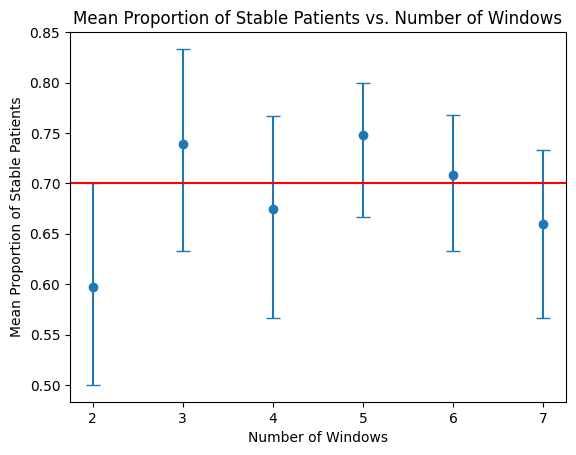

In [140]:
results = []
for n in range(2, 8):
    stable_proportions = check_stability(rank_data, n, stability_threshold, num_iterations)
    mean_prop, ci_lower, ci_upper, p_value = calculate_p_value(stable_proportions, goal_stability)
    results.append((n, mean_prop, ci_lower, ci_upper, p_value))

# Print the results
for result in results:
    print(f"Windows: {result[0]}, Mean Proportion: {result[1]}, CI: [{result[2]}, {result[3]}], P-Value: {result[4]}")

# Plot the results
window_sizes, mean_props, ci_lowers, ci_uppers, p_values = zip(*results)

yerr = np.array([(mean_props[i] - ci_lowers[i], ci_uppers[i] - mean_props[i]) for i in range(len(mean_props))]).T

plt.errorbar(window_sizes, mean_props, yerr=yerr, fmt='o', capsize=5)
plt.axhline(y=goal_stability, color='r', linestyle='-')
plt.xlabel('Number of Windows')
plt.ylabel('Mean Proportion of Stable Patients')
plt.title('Mean Proportion of Stable Patients vs. Number of Windows')
plt.show()